In [ ]:
%pip install -U tf-agents pyvirtualdisplay
%pip install -U gym>=0.21.0
%pip install -U gym[box2d,atari,accept-rom-license]

     |████████████████████████████████| 1.3 MB 6.4 MB/s 
     |████████████████████████████████| 18.3 MB 57 kB/s 
     |████████████████████████████████| 1.6 MB 6.5 MB/s 
     |████████████████████████████████| 2.1 MB 28.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=96e2d888a699761a0c3345e3d7e806591950290d28811610183cab18f0dd22f5
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [ ]:
import matplotlib
import gym
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from itertools import count
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
env=gym.make("ALE/Boxing-v5")


In [ ]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()

        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32

        self.model_conv = nn.Sequential(nn.Conv2d(3, 3, kernel_size=5, stride=2),
                              nn.BatchNorm2d(3),
                              nn.ReLU(),
                              nn.Conv2d(3, 18, kernel_size=5, stride=2),
                              nn.BatchNorm2d(18),
                              nn.ReLU(),
                              nn.Conv2d(18, 32, kernel_size=5, stride=2),
                              nn.BatchNorm2d(32),
                              nn.ReLU(),
                              )
        self.model_linear = nn.Sequential(nn.Linear(linear_input_size, 32),
                                     nn.ReLU(),
                                     nn.Linear(32, 32),
                                     nn.ReLU()
                                     )
        self.actor = nn.Sequential(nn.Linear(32, outputs),
                                     nn.Softmax() )
        self.critic = nn.Sequential(nn.Linear(32, 1),
                                     nn.Tanh() )


    def forward(self, x):
        x = x.to(device)
        x = self.model_conv(x)
        x = self.model_linear(x.view(x.size(0), -1))
        return self.critic(x) , self.actor(x)

In [ ]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(30, interpolation=Image.CUBIC),
                    T.ToTensor()])


def reduce_dim(obs):
    obs = obs.transpose((2, 0, 1))
    obs = torch.from_numpy(obs)
    return resize(obs).unsqueeze(0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:

Learning_rate = 0.001
GAMMA=0.9

obs = reduce_dim(env.reset())
_, _,height, width = obs.shape
n_actions = env.action_space.n

agent = DQN(height, width, n_actions).to(device)
optimizer = optim.RMSprop(agent.parameters(),lr=Learning_rate)


In [ ]:
EPS_START = 0.9
EPS_END = 0.001
EPS_DECAY = 14000

def select_action(state):
    _, actions =agent(state)
    action_probs= torch.distributions.Categorical(probs=actions)
    return   action_probs.sample()


In [ ]:
def update_network(state, action,reward,next_state,done,t):
  global steps_done , GAMMA
  optimizer.zero_grad()
  state_val, probs = agent(state)
  next_state_val, _ = agent(next_state)
  
  action_probs= torch.distributions.Categorical(probs=probs)
  log_prob = action_probs.log_prob(action)
  theta = reward + GAMMA*next_state_val*(1-int(done)) - state_val
  theta1 = (GAMMA**(t-1))*theta
  actor_loss= -1*theta1*log_prob
  critic_loss = theta**2 #state_val
  loss = actor_loss + critic_loss
  
  loss.backward()
  optimizer.step()



In [ ]:
num_episodes = 100
rewardPerEpisode=[]
action_taken=[]
time_taken=[]
eps = []
for i_episode in range(num_episodes):
    obs = env.reset()
    state = reduce_dim(obs)
    acc_reward= 0 
    for t in count():

        action = select_action(state)
        action_taken.append(action.item())
        obs, reward, done, _ = env.step(action.item())

        acc_reward += reward
        next_state = reduce_dim(obs)

        reward = torch.tensor([reward], device=device)
        update_network(state,action,reward,next_state,done,t)
        state = next_state
        if done :
          rewardPerEpisode.append(acc_reward)
          time_taken.append(t)
          break
    print(i_episode,rewardPerEpisode[i_episode], time_taken[i_episode])

print('Complete')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 -1.0 1786
1 -6.0 1786
2 -3.0 1786
3 1.0 1786
4 0.0 1786
5 -1.0 1786
6 0.0 1786
7 10.0 1786
8 5.0 1786
9 -3.0 1786
10 7.0 1786
11 -6.0 1786
12 1.0 1786
13 -1.0 1786
14 -3.0 1786
15 0.0 1786
16 0.0 1786
17 0.0 1786
18 -3.0 1786
19 -11.0 1786
20 2.0 1786
21 -4.0 1786
22 12.0 1786
23 3.0 1786
24 -1.0 1786
25 1.0 1786
26 0.0 1786
27 4.0 1786
28 0.0 1786
29 -22.0 1786
30 3.0 1786
31 -3.0 1786
32 0.0 1786
33 0.0 1786
34 1.0 1786
35 3.0 1786
36 -4.0 1786
37 -2.0 1786
38 -5.0 1786
39 1.0 1786
40 9.0 1786
41 2.0 1786
42 -1.0 1786
43 11.0 1786
44 -1.0 1786
45 2.0 1786
46 -3.0 1786
47 0.0 1786
48 0.0 1786
49 0.0 1786
50 -1.0 1786
51 -17.0 1786
52 -1.0 1786
53 7.0 1786
54 2.0 1786
55 0.0 1786
56 -9.0 1786
57 0.0 1786
58 -11.0 1786
59 -12.0 1786
60 -4.0 1786
61 -1.0 1786
62 13.0 1786
63 -2.0 1786
64 6.0 1786
65 -2.0 1786
66 -2.0 1786
67 0.0 1786
68 3.0 1786
69 3.0 1786
70 -3.0 1786
71 0.0 1786
72 -10.0 1786
73 17.0 1786
74 -4.0 1786
75 10.0 1786
76 12.0 1786
77 0.0 1786
78 -1.0 1786
79 1.0 1786
80

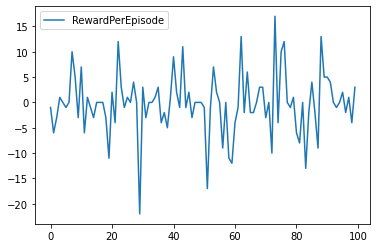

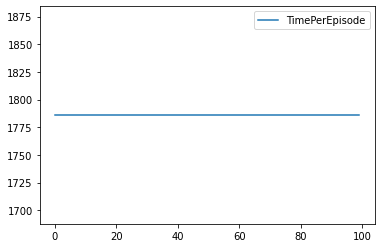

In [ ]:
plt.plot(rewardPerEpisode, label="RewardPerEpisode")
plt.legend()
plt.figure()
plt.plot(time_taken, label= "TimePerEpisode")
plt.legend()
plt.show()

In [ ]:
num_episodes = 10
rewardPerEpisode=[]
action_taken=[]
time_taken=[]
eps = []
for i_episode in range(num_episodes):
    obs = env.reset()
    state = reduce_dim(obs)
    acc_reward= 0 
    for t in count():

        action  = select_action(state)
        action_taken.append(action.item())
        obs, reward, done, _ = env.step(action.item())

        acc_reward += reward
        next_state = reduce_dim(obs)

        state = next_state
        if done :
          rewardPerEpisode.append(acc_reward)
          time_taken.append(t)
          break
    print(i_episode,rewardPerEpisode[i_episode], time_taken[i_episode])

print('Complete')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 -4.0 1786
1 3.0 1786
2 4.0 1786
3 2.0 1786
4 -5.0 1786
5 -2.0 1786
6 2.0 1786
7 -9.0 1786
8 1.0 1786
9 2.0 1786
Complete


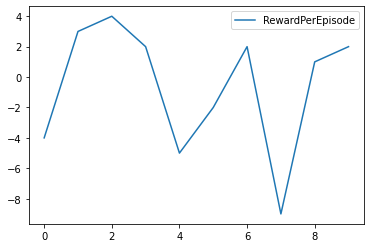

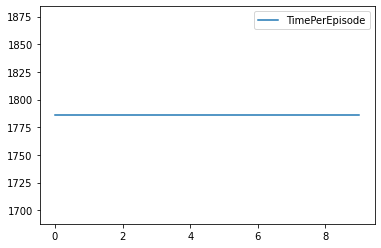

In [ ]:
plt.plot(rewardPerEpisode, label="RewardPerEpisode")
plt.legend()
plt.figure()
plt.plot(time_taken, label= "TimePerEpisode")
plt.legend()
plt.show()